In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import torch.nn.functional as F

import seaborn

import matplotlib.pyplot as plt

# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.005


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class CIFAR10_CNN(nn.Module):
  def __init__(self):
    super(CIFAR10_CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
    self.relu = nn.ReLU()
    
    self.fc = nn.Linear(16384, 10)
    
  def forward(self, x):
    out = self.conv1(x)
    out = self.relu(out)
    
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    
    return out

model = CIFAR10_CNN().to(device)

In [2]:


# CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='.',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='.',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1, 
                                          shuffle=False)

0it [00:00, ?it/s]

100%|█████████▉| 170401792/170498071 [00:44<00:00, 3368896.67it/s]

In [3]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


170500096it [01:00, 3368896.67it/s]                               

In [4]:
rejected_classes = torch.zeros([10])

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

import time
start = time. time()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        
        # rejection condition
        smax = F.softmax(outputs.data, dim = 1)
#         print(smax)
        
        if (torch.max(smax),1)[0] < 0.2:
          rejected_classes[labels.item()] += 1
          
        
        
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    end = time. time()
    print(end - start)
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


7.837756633758545
Test Accuracy of the model on the 10000 test images: 44.42 %


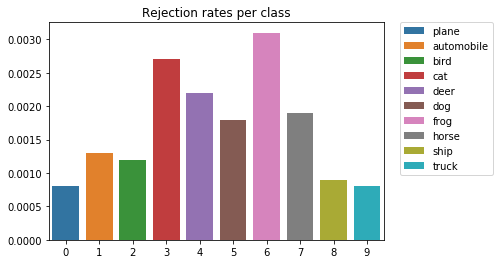

In [5]:
mis_ratio = rejected_classes/10000

classes = ('plane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
seaborn.barplot(x=[0,1,2,3,4,5,6,7,8,9], y=mis_ratio, hue=classes, dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Rejection rates per class")
plt.show()